<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200412_ObjectDetection/mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import files from your PC to colab

In [1]:
from google.colab import files
uploaded = files.upload()
for k, v in uploaded.items():
    open(k, 'wb').write(v)

In [2]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
image_path = '1_EYFejGUjvjPcc4PZTwoufw.jpeg'
img = mpimg.imread(image_path)
# np.array
print(img.shape) 

(586, 872, 3)


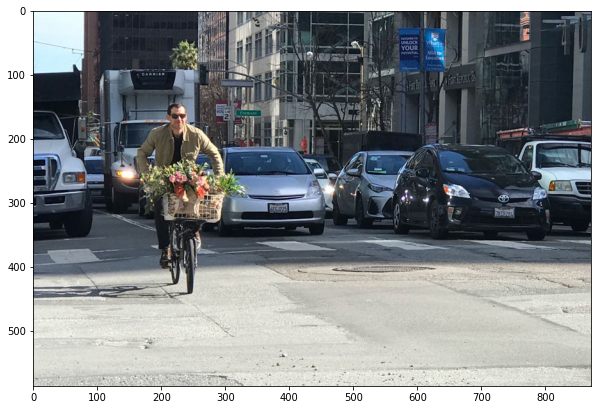

In [3]:
fig = plt.figure(figsize=(10,8))
plt.imshow(img)

# Data Pre-processing

In [0]:
# img_np = img / 255.0
img_np = img.copy()

# Import Model

In [5]:
try:
    %tensorflow_version 2.x 
except: 
    pass

import tensorflow as tf
import pathlib

print('Tensorflow\'s version: {}'.format(tf.__version__))

Tensorflow's version: 2.2.0-rc2


In [0]:
# Ref: https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name
        , origin=base_url + model_file
        , untar=True)
    model_dir = pathlib.Path(model_dir)/"saved_model"

    print('{} is going to be loaded.'.format(str(model_dir)))
    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

In [7]:
# model list: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
# here is the example: ssd_mobilenet_v2_coco
# http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
model = load_model('ssd_mobilenet_v2_coco_2018_03_29')

/root/.keras/datasets/ssd_mobilenet_v2_coco_2018_03_29/saved_model is going to be loaded.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
print(model.inputs)
print(model.output_dtypes)
print(model.output_shapes)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]
{'detection_scores': tf.float32, 'detection_classes': tf.float32, 'num_detections': tf.float32, 'detection_boxes': tf.float32}
{'detection_scores': TensorShape([None, 100]), 'detection_classes': TensorShape([None, 100]), 'num_detections': TensorShape([None]), 'detection_boxes': TensorShape([None, 100, 4])}


# Get influence from the model

In [9]:
# convert from np to tensor
input_tensor = tf.convert_to_tensor(img_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis,...]
print(input_tensor.shape)

(1, 586, 872, 3)


In [0]:
output_dict = model(input_tensor)
# all outputs are tensor. convert them to numpy.
for key, value in output_dict.items():
    output_dict[key] = value.numpy().squeeze()
output_dict['detection_classes'] = output_dict['detection_classes'].astype('int')
output_dict['num_detections'] = output_dict['num_detections'].astype('int')

In [11]:
# print
for key, value in output_dict.items():
    print(key, ':', value.shape, value.dtype)

# 4 objects: detection_classes , num_detections , detection_boxes , detection_scores 
# detection_masks may be there. Handle this later.

detection_scores : (100,) float32
detection_classes : (100,) int64
num_detections : () int64
detection_boxes : (100, 4) float32


# Visualizing those boxes

In [0]:
# Installing object-detection library in tf

import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [13]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017522 sha256=4a6050b9c89da139d0c568b74697942b0f1bb55591035c99926a45396cbc034c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ucyaoro/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [0]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

In [0]:
# tf patches
# utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [16]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

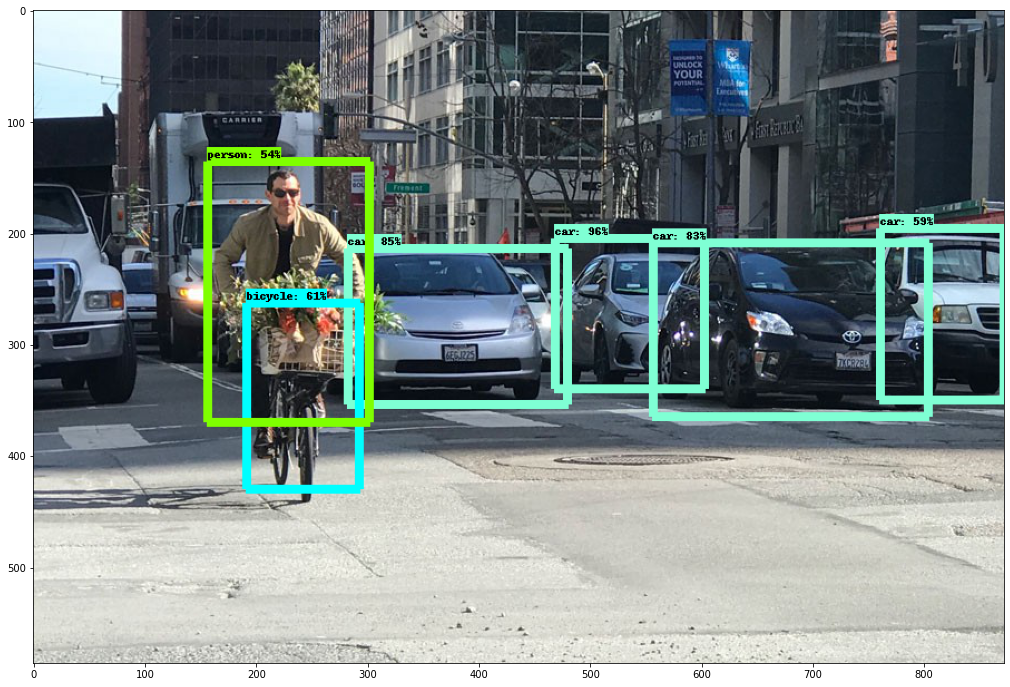

In [17]:
vis_util.visualize_boxes_and_labels_on_image_array(
    img_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)

# display(Image.fromarray(img_np))
plt.figure(figsize=(24,12))
plt.imshow(img_np)